In [24]:
import os
import h5py
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors
import numpy as np
from iminuit import minuit
from iminuit.cost import LeastSquares
import pandas as pd
from scipy import constants

matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [129]:
parent = r'C:\Users\ricca\Desktop\MAGISTRALE\QTLab2324\IRdetection\Test_data\data_19_02_set1'

In [130]:
def reader(parent):

    data = {
        "res1" : [],
        "res2" : [],
        "res3" : [],
        "res4" : []
    }

    for folder in os.listdir(parent):
        if folder.startswith("T"):
            T = folder.replace('T_','')
            for file in os.listdir(parent + '/' + folder):
                dic = {
                    'F' : [],
                    'I' : [],
                    'Q' : [],
                }
                with h5py.File(parent + '/' + folder + '/' + file, 'r') as f:
                    dic['F'] = np.array(f['raw_data']['f'][:])
                    dic['I'] = np.array(f['raw_data']['i'][:])
                    dic['Q'] = np.array(f['raw_data']['q'][:])
                    if '1' in file:
                        data['res1'].append([T, dic])
                    elif '2' in file:
                        data['res2'].append([T, dic])
                    elif '3' in file:
                        data['res3'].append([T, dic])
                    elif '4' in file:
                        data['res4'].append([T, dic])
    
    return data 

In [131]:
data = reader(parent)
polyorder = 2

In [132]:
def resonance_model(x, pars):
    return 1-pars[1]*np.exp(1j*pars[2])/(1-1j*((2*x*pars[0])-pars[3]))

def model(x, *pars):
    pol = np.polyval(pars[:polyorder+1], x)
    res = resonance_model(x, pars[polyorder+1:])
    return np.abs(res)+pol



In [133]:
p0 = [1e-6,1e-3,1,1e4, 0.5, 1, 0]

In [134]:
T = []
for i in range(len(data['res2'])):
    T.append(data['res2'][i][0])

In [135]:
def compute_Qi_err(Q, R, phi, sQ, sR, sphi):
    a = ((1-R*np.cos(phi))/Q**2)**2*sQ**2
    b = ((1-np.cos(phi))/Q)**2*sR**2
    c = ((1+R*np.sin(phi))*R/Q)**2*sphi**2
    return np.sqrt(a+b+c)

def compute_Qc_err(Q, R, phi, sQ, sR, sphi):
    a = 1/(R*np.cos(phi))**2*sQ**2
    b = (Q/(R**2*np.cos(phi))**2)**2*sR**2
    c = (Q*np.sin(phi)/(R*np.cos(phi)**2))**2*sphi**2
    return np.sqrt(a+b+c)

C:\Users\ricca\AppData\Local\Temp\ipykernel_5324\671219090.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1,1,figsize=(10,5))


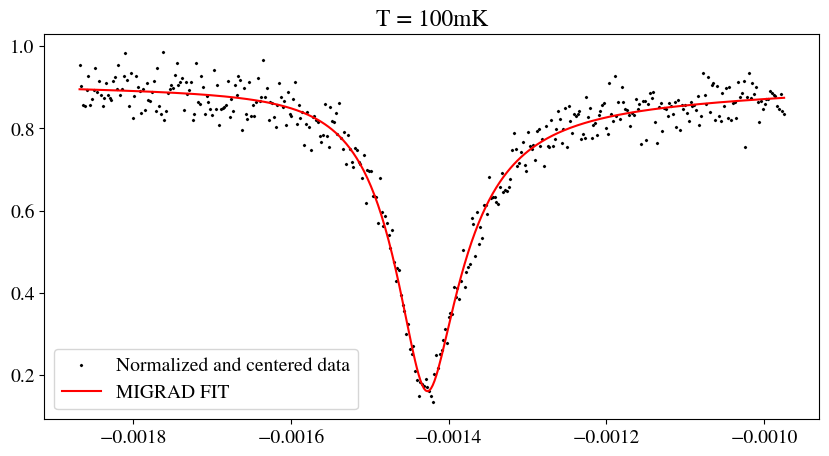

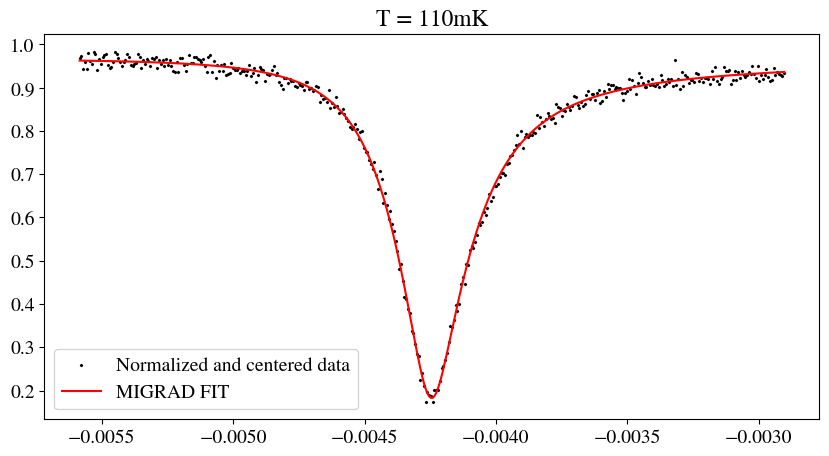

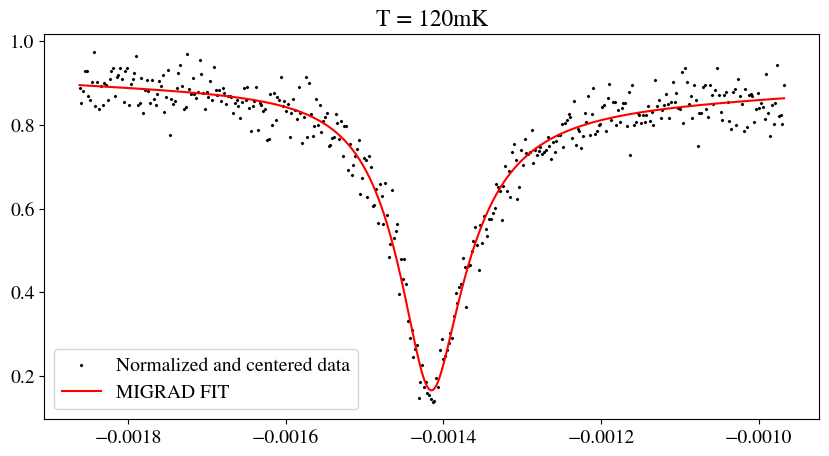

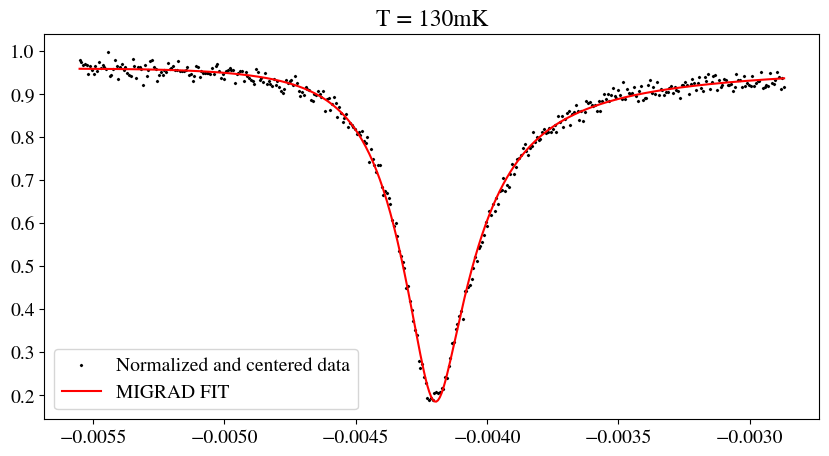

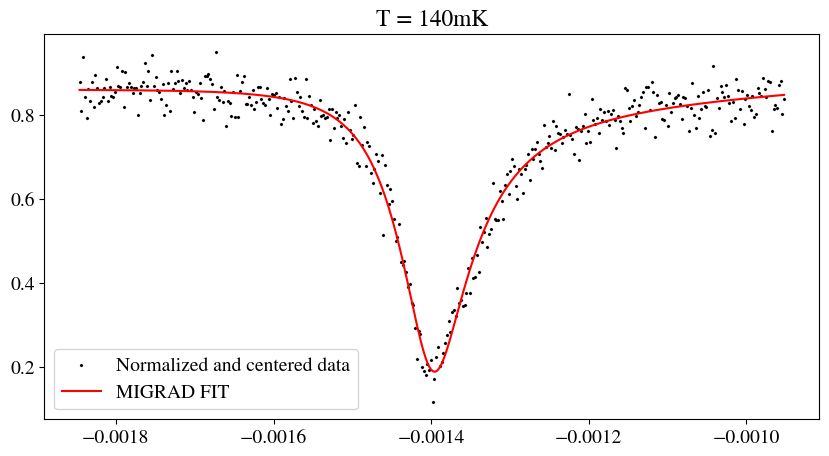

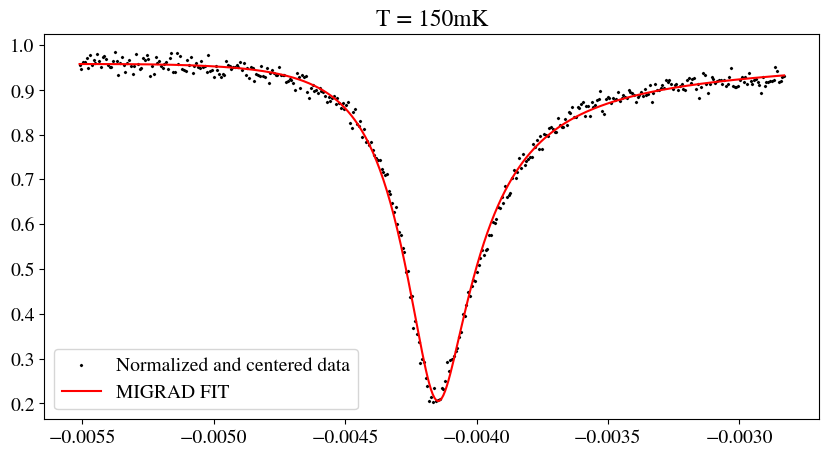

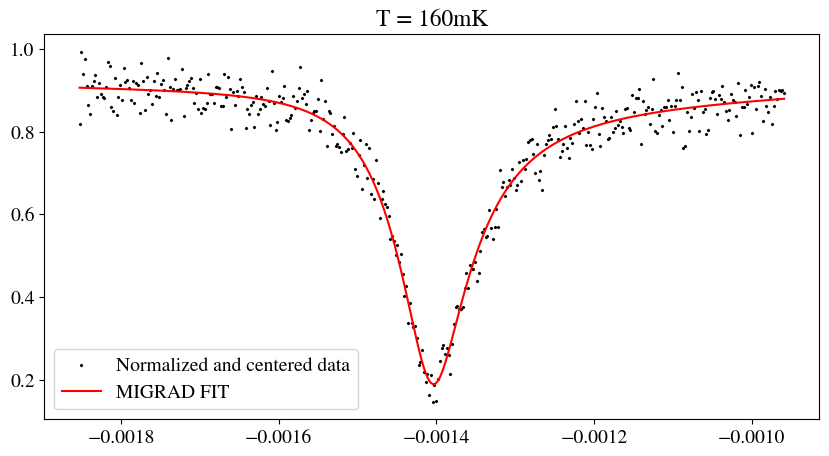

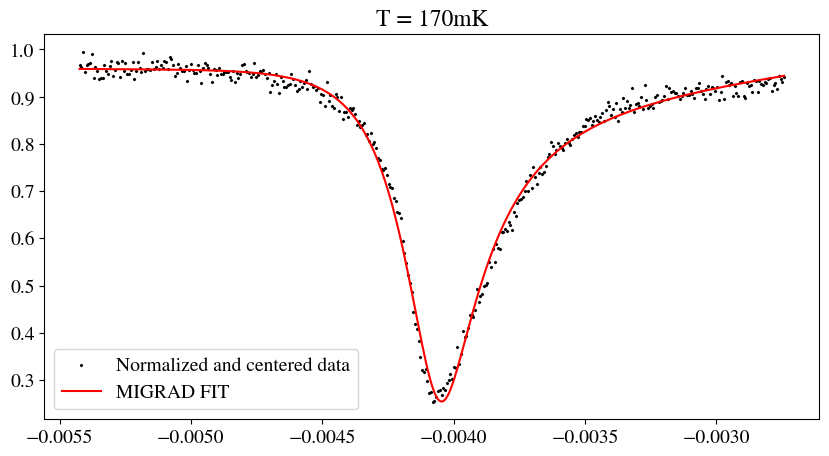

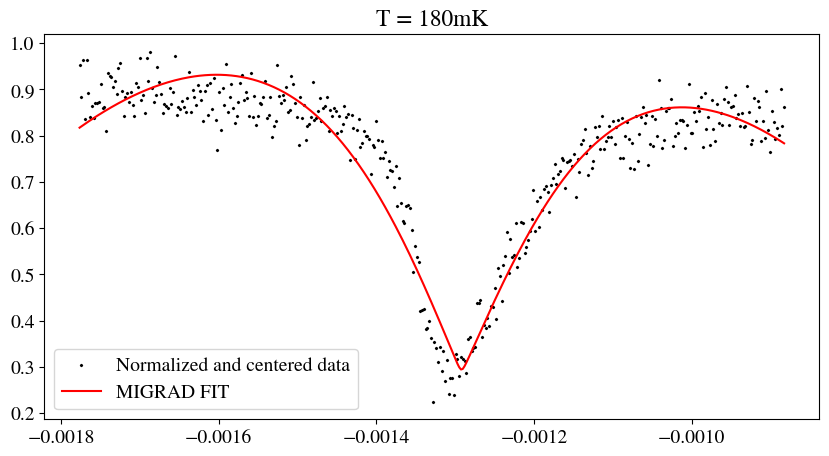

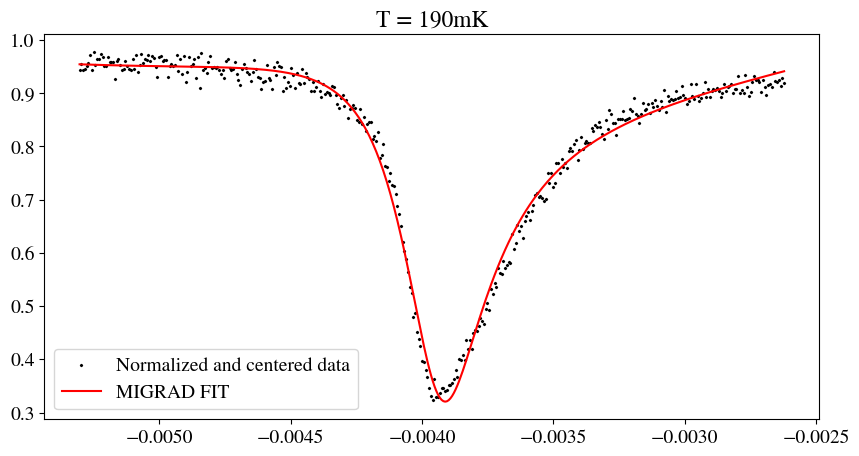

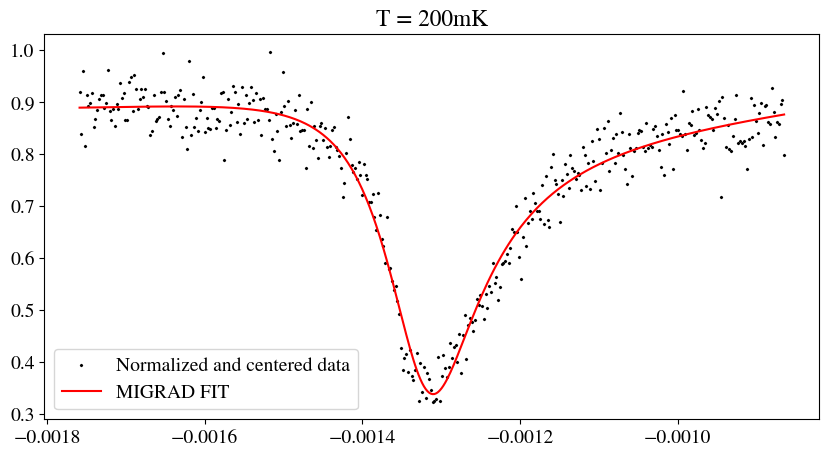

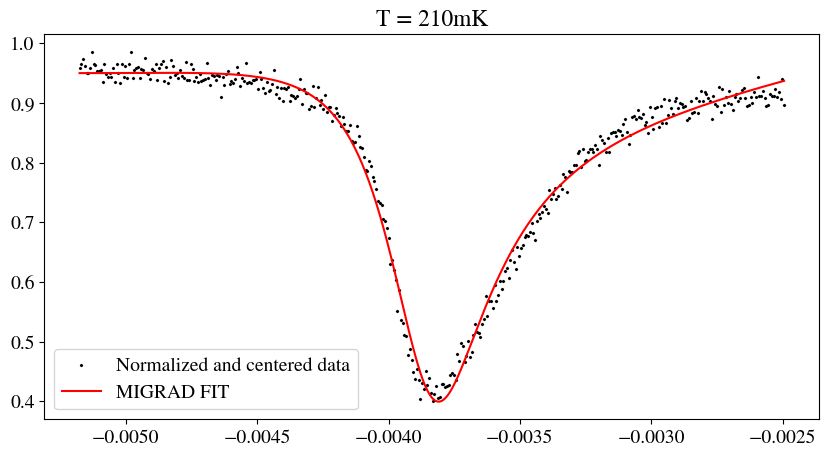

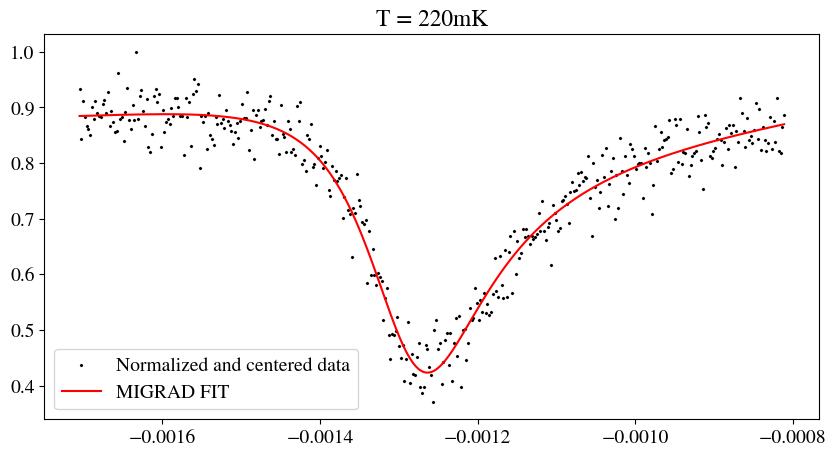

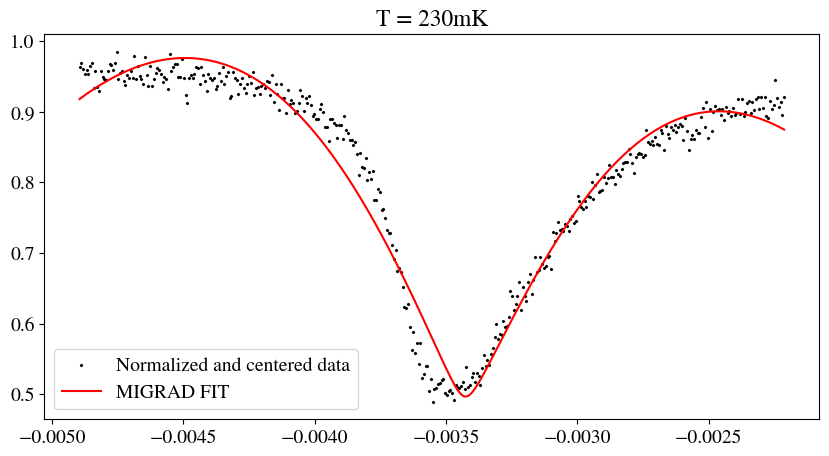

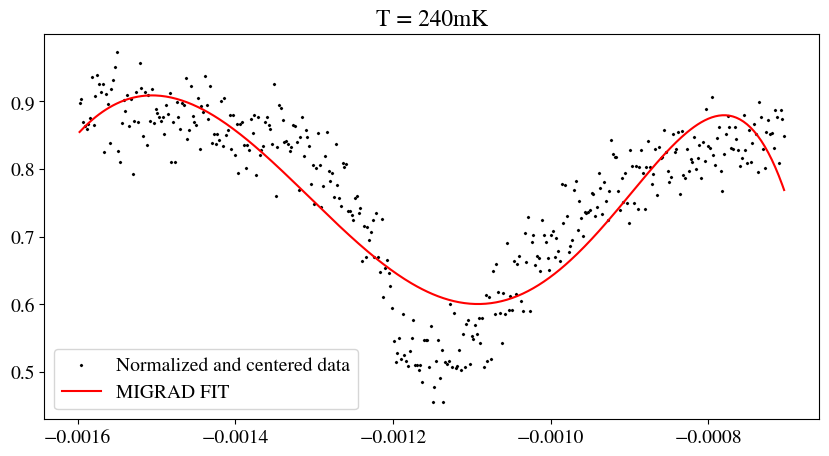

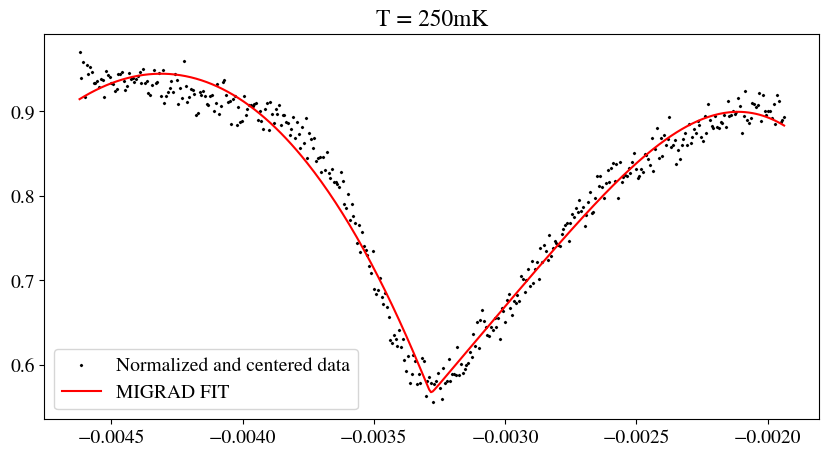

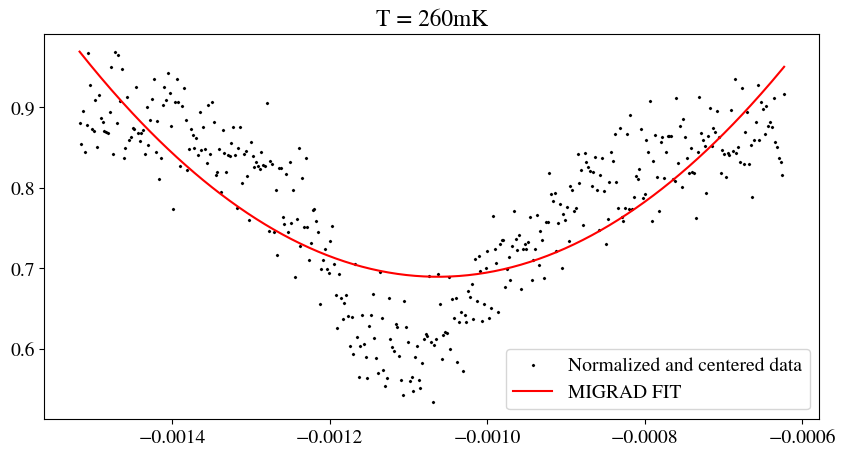

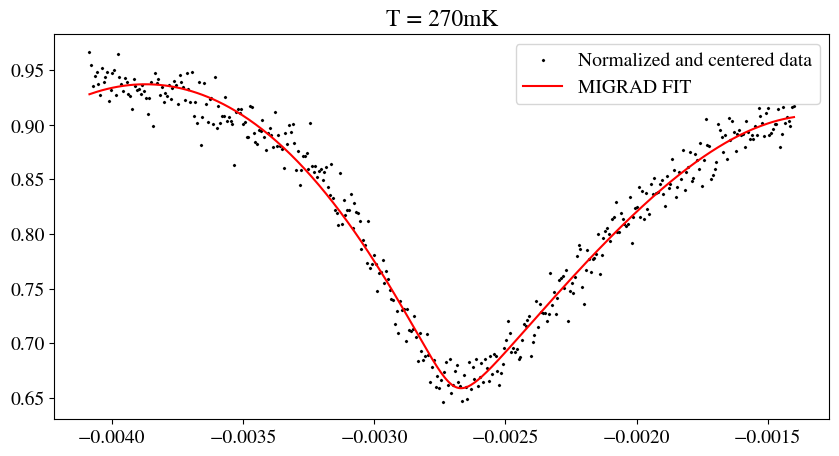

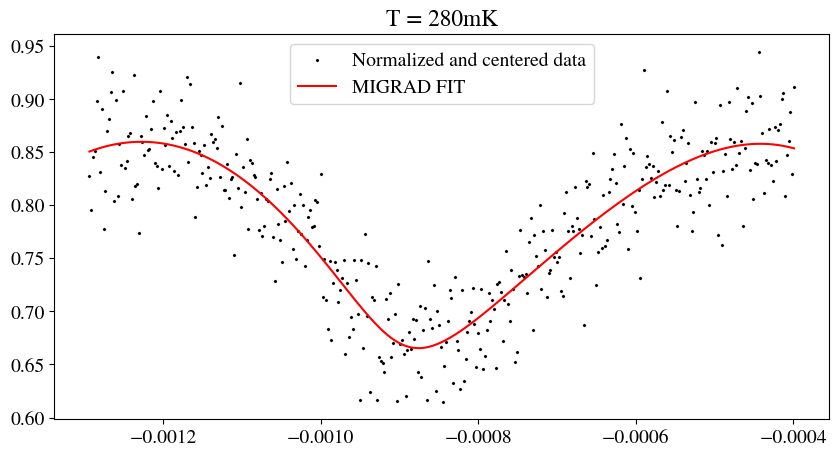

In [136]:
dic = {
    'Q' : [],
    'sQ' : [],
    'Qc' : [],
    'sQc' : [],
    'Qi' : [],
    'sQi' : [],
    'T' : []
}
prob = []
for i in range(len(T)):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    F = np.array(data['res2'][i][1]['F'])
    C = np.array(data['res2'][i][1]['Q'])+1j*np.array(data['res2'][i][1]['I'])
    A = np.abs(C)
    P = np.unwrap(np.angle(C))
    A /= max(A)
    F = (F - F[np.argmin(A)])/F[np.argmin(A)]
    a = np.polyfit(F,P,1)
    P = P - np.polyval(a,F)
    A = A[np.argmin(A)-200:np.argmin(A)+200]
    F = F[np.argmin(A)-200:np.argmin(A)+200]
    P = P[np.argmin(A)-200:np.argmin(A)+200]
    len_fit = int(np.floor(len(A)/10))
    pol_amp = np.polyfit(F[:len_fit], A[:len_fit], 2)
    A_rms = np.sqrt(np.mean((np.polyval(pol_amp, F[:len_fit])-A[:len_fit])**2))        


    len_fit = int(np.floor(len(P)/10))
    pol_ph = np.polyfit(F[:len_fit], P[:len_fit], 2)
    P_rms = np.sqrt(np.mean((np.polyval(pol_ph, F[:len_fit])-P[:len_fit])**2))

    p0 = [1e-6,1e-3,1,1e4, 0.5, 1, 0]

    lsq = LeastSquares(F,A,A_rms*np.ones(len(A)),model)
    m= minuit.Minuit(lsq, *p0)
    ##m.limits['x3'] = (0,1e4)
    #m.limits['x4'] = (0,10)
    m.migrad(ncall=10000, iterate=1000)

    #plt.errorbar(F,A,np.ones_like(A)*A_rms,linestyle='')
    axs.scatter(F,A,s=2,marker='x',color='black',label='Normalized and centered data');
    axs.plot(F,model(F,*m.values),color='red',label='MIGRAD FIT');
    axs.set_title('T = '+str(T[i])+'mK')
    axs.legend()
    fig.savefig(r'C:\Users\ricca\Desktop\MAGISTRALE\QTLab2324\IRdetection\Notebooks\pngs\res1_'+str(T[i])+'.png')
    Q = m.values[polyorder+1]
    R = m.values[polyorder+2]
    phi = m.values[polyorder+3]
    Qi = Q/(1-R*(np.cos(phi)))
    Qc = Q/(R*(np.cos(phi)))

    if (Qi>0 and Q>0 and Qc>0 and m.fval/m.ndof < 2):
        dic['Qi'].append(float(1/Qi))
        dic['sQi'].append(compute_Qi_err(Q,R,phi,m.errors[polyorder+1],m.errors[polyorder+2],m.errors[polyorder+3]))
        dic['Q'].append(float(Q))
        dic['sQ'].append(float(m.errors[polyorder+1]))
        dic['Qc'].append(float(Qc))
        dic['sQc'].append(compute_Qc_err(Q,R,phi,m.errors[polyorder+1],m.errors[polyorder+2],m.errors[polyorder+3]))
        dic['T'].append(int(T[i]))
    else:
        prob.append(i)

In [111]:
i = T.index('210')
print(T[i])
F = np.array(data['res1'][i][1]['F'])
C = np.array(data['res1'][i][1]['Q'])+1j*np.array(data['res1'][i][1]['I'])
A = np.abs(C)
P = np.unwrap(np.angle(C))
A /= max(A)
F = (F - F[np.argmin(A)])/F[np.argmin(A)]
a = np.polyfit(F,P,1)
P = P - np.polyval(a,F)
A = A[np.argmin(A)-400:np.argmin(A)+400]
F = F[np.argmin(A)-400:np.argmin(A)+400]
P = P[np.argmin(A)-400:np.argmin(A)+400]

210


In [122]:
p0 = [-800,-18,-0.1,18e2, 0.68, 6.3, -9.15]

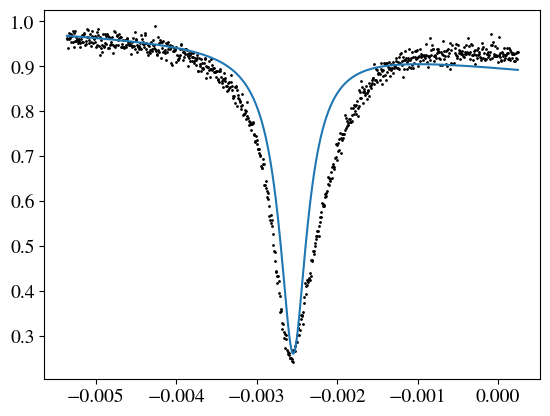

In [123]:
plt.scatter(F,A,color='black',s=1)
plt.plot(F,model(F,*p0))
Qi = Q/(1-R*(np.cos(phi)))

In [124]:
lsq = LeastSquares(F,A,A_rms*np.ones(len(A)),model)
m= minuit.Minuit(lsq, *p0)
m.limits['x3'] = (0,1e4)
m.limits['x4'] = (0,10)
m.migrad(ncall=10000, iterate=1000);

Q = m.values[polyorder+1]
R = m.values[polyorder+2]
phi = m.values[polyorder+3]
Qi = Q/(1-R*(np.cos(phi)))
Qc = Q/(R*(np.cos(phi)))
print(Qi)

3667.3818828005947


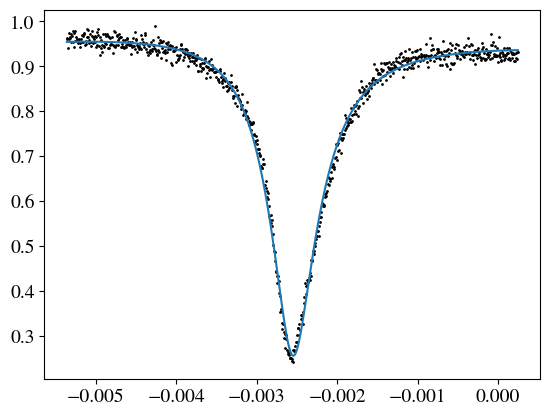

In [125]:
plt.scatter(F,A,color='black',s=1)
plt.plot(F,model(F,*m.values))

In [126]:
dic['Qi'].append(float(1/Qi))
dic['sQi'].append(compute_Qi_err(Q,R,phi,m.errors[polyorder+1],m.errors[polyorder+2],m.errors[polyorder+3]))
dic['Q'].append(float(Q))
dic['sQ'].append(float(m.errors[polyorder+1]))
dic['Qc'].append(float(Qc))
dic['sQc'].append(compute_Qc_err(Q,R,phi,m.errors[polyorder+1],m.errors[polyorder+2],m.errors[polyorder+3]))
dic['T'].append(int(T[i]))

In [127]:
sorted_indices = np.argsort(dic['T'])
dic['T'] = [dic['T'][i] for i in sorted_indices] 
dic['Q'] = [dic['Q'][i] for i in sorted_indices] 
dic['Qc'] = [dic['Qc'][i] for i in sorted_indices]
dic['Qi'] = [dic['Qi'][i] for i in sorted_indices]


df = pd.DataFrame(dic)
df_sorted = df.sort_values(by='T')
df_sorted.reset_index(drop=True, inplace=True)

print(df)

              Q         sQ           Qc        sQc        Qi       sQi    T
0   1984.335329  16.513894  2253.580975  22.988769  0.000060  0.000004   50
1   1263.774778  12.431348  1416.644700  17.704363  0.000085  0.000003   60
2   2042.493140   8.801184  2358.814889  16.223148  0.000066  0.000002   70
3   1258.702574  17.134949  1428.274262  25.939764  0.000094  0.000005   80
4   1296.832857  14.257509  1513.415337  22.288531  0.000110  0.000004   90
5   1280.988683  16.230906  1483.419211  24.821238  0.000107  0.000005  100
6   1269.062410  18.247392  1455.480670  25.725744  0.000101  0.000002  110
7   1264.577412  13.276854  1455.404711  22.383049  0.000104  0.000003  120
8   2019.775405  15.235952  2314.504347  21.469250  0.000063  0.000004  130
9   1247.873021   6.696070  1434.027102   9.940397  0.000104  0.000002  140
10  1286.500205  10.468222  1512.225336  17.042143  0.000116  0.000001  150
11  1964.784069   6.731926  2268.077232   9.706427  0.000068  0.000002  160
12  1261.390

In [128]:
df.to_csv('Results.txt','\t')

C:\Users\ricca\AppData\Local\Temp\ipykernel_5324\829242727.py:1: FutureWarning: Starting with pandas version 3.0 all arguments of to_csv except for the argument 'path_or_buf' will be keyword-only.
  df.to_csv('Results.txt','\t')


In [41]:
x = dic['T'][::2]
y = dic['Qi'][::2]
yerr = dic['sQi'][::2]

(50.0, 270.0)

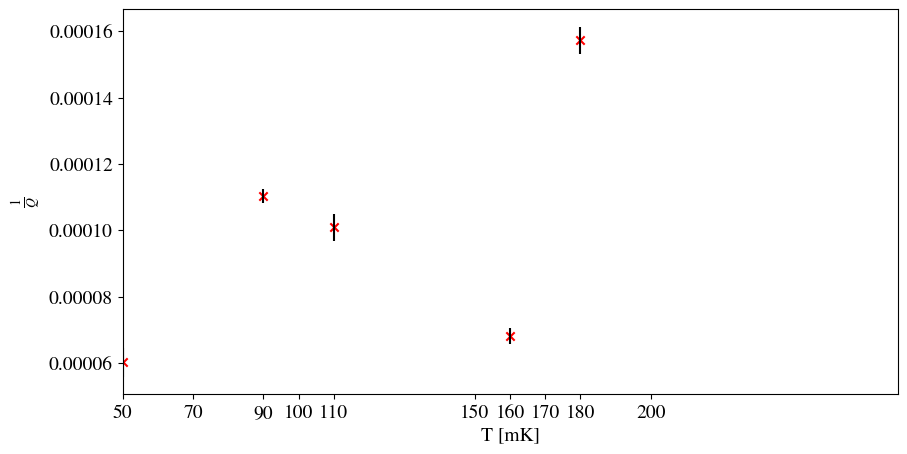

In [42]:
plt.figure(figsize=(10,5))
plt.errorbar(x,y,yerr,color='black',linestyle='')
plt.scatter(x,y,color='red',marker='x')
plt.xticks(dic['T']);
plt.ylabel(r'$\frac{1}{Q}$')
plt.xlabel(r'T [mK]')
plt.xlim([50,270])

In [43]:
x = np.array([x[i] for i in range(len(x)) if x[i]!=190])
y = np.array([y[i] for i in range(len(x)) if x[i]!=190])
yerr = np.array([yerr[i] for i in range(len(x)) if x[i]!=190])

In [44]:
from scipy.constants import constants
from scipy.special import iv, kv
hbar = constants.Planck
omega = 3.03*1e9/(2*np.pi)
KB = constants.Boltzmann
alpha = 0.8669

pgap = [2.1*1e-23, 0.130, 1e-6, y[0]]

def GapModel(val_t, delta0, Tk, b, q0):
    val_t = val_t * 1e-3
    xi = hbar * omega / (2 * KB * val_t)
    sigma1 = 4*np.exp(-delta0/(KB*val_t))*np.sinh(xi)*kv(0, xi)
    sigma2 = np.pi*(1-2*np.exp(-delta0/(KB*val_t))*np.exp(-xi)*iv(0, xi))
    
    return -b*np.log(val_t*1e3/Tk) + 1*alpha*sigma1/sigma2 + q0

C:\Users\ricca\AppData\Local\Temp\ipykernel_5324\1705735825.py:3: DeprecationWarning: Please use `Planck` from the `scipy.constants` namespace, the `scipy.constants.constants` namespace is deprecated.
  hbar = constants.Planck
C:\Users\ricca\AppData\Local\Temp\ipykernel_5324\1705735825.py:5: DeprecationWarning: Please use `Boltzmann` from the `scipy.constants` namespace, the `scipy.constants.constants` namespace is deprecated.
  KB = constants.Boltzmann


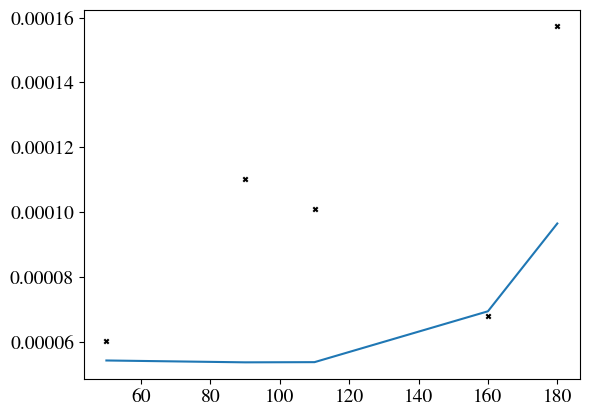

In [45]:
plt.plot(x,GapModel(x,*pgap))
plt.scatter(x,y,s=10,marker='x',color='black')

In [46]:
lsq = LeastSquares(x,y,0.0001,GapModel)
m= minuit.Minuit(lsq, *pgap)
##m.limits['x3'] = (0,1e4)
#m.limits['x4'] = (0,10)
m.migrad(ncall=10000, iterate=1000)

C:\Users\ricca\AppData\Local\Temp\ipykernel_5324\1705735825.py:13: RuntimeWarning: overflow encountered in exp
  sigma1 = 4*np.exp(-delta0/(KB*val_t))*np.sinh(xi)*kv(0, xi)
C:\Users\ricca\AppData\Local\Temp\ipykernel_5324\1705735825.py:14: RuntimeWarning: overflow encountered in exp
  sigma2 = np.pi*(1-2*np.exp(-delta0/(KB*val_t))*np.exp(-xi)*iv(0, xi))
C:\Users\ricca\AppData\Local\Temp\ipykernel_5324\1705735825.py:16: RuntimeWarning: invalid value encountered in divide
  return -b*np.log(val_t*1e3/Tk) + 1*alpha*sigma1/sigma2 + q0


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.9171 (χ²/ndof = 0.9)     │             Nfcn = 36027             │
│ EDM = nan (Goal: 0.0002)         │            time = 2.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ delta0 │  2.1e-23  │    nan    │            │            │         │         │       │
│ 1 │ Tk     │  1.3e-1   │    nan    │            │            │         │         │       │
│ 2 │ b      │   1e-6    │    nan    │            │            │         │         │       │
│ 3 │ q0     │ 6.0209e-5 │    nan    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────┐
│        │ delta0     Tk      b     q0 │
├────────┼─────────────────────────────┤
│ delta0 │    nan    nan    nan    nan │
│     Tk │    nan    nan    nan    nan │
│      b │    nan    nan    nan    nan │
│     q0 │    nan    nan    nan    nan │
└────────┴─────────────────────────────┘

C:\Users\ricca\AppData\Local\Temp\ipykernel_5324\1705735825.py:16: RuntimeWarning: invalid value encountered in log
  return -b*np.log(val_t*1e3/Tk) + 1*alpha*sigma1/sigma2 + q0


<ErrorbarContainer object of 3 artists>

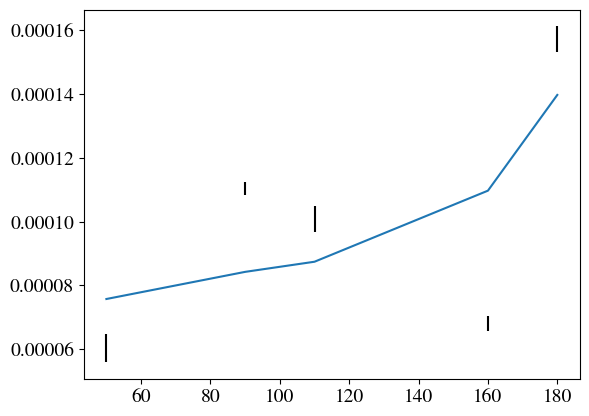

In [47]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(GapModel, x, y, pgap)
plt.plot(x,GapModel(x,*popt))
plt.errorbar(x,y,yerr,color='black',linestyle='')

In [48]:
print(r'Delta = '+str(popt[0]/constants.eV*1e4)+' meV +/- '+str(np.diag(pcov)[0]))

Delta = 1.303714892717622 meV +/- 7.42468670610766e-47


C:\Users\ricca\AppData\Local\Temp\ipykernel_5324\3186777680.py:1: DeprecationWarning: Please use `eV` from the `scipy.constants` namespace, the `scipy.constants.constants` namespace is deprecated.
  print(r'Delta = '+str(popt[0]/constants.eV*1e4)+' meV +/- '+str(np.diag(pcov)[0]))
